In [1]:
# 파이토치
import torch
import torch.nn.functional as F
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time
import os
from tqdm import tqdm_notebook
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [2]:
device

device(type='cpu')

In [4]:
import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

# 한글 폰트 설정하기
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=10)
# plt.rc('font', family='NanumBarunGothic')
# matplotlib.font_manager._rebuild()

In [12]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = '/Users/ppangppang/Desktop/ssac/Final_project/2.Processed/image/'
data_dir = '/Users/ppangppang/Desktop/ssac/Final_project/2.Processed/image/check'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=16, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 379
테스트 데이터셋 크기: 60
클래스: ['hat', 'jeans', 'labtop']


In [13]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# # 학습 데이터를 배치 단위로 불러오기
# iterator = iter(train_dataloader)

# # 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
# inputs, classes = next(iterator)
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x] for x in classes])

In [14]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 51개로 교체하여 마지막 레이어 다시 학습

model.fc = nn.Linear(num_features, 3)
# model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
num_epochs = 2 #50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in tqdm_notebook(range(num_epochs),desc="epoch"):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in tqdm_notebook(train_dataloader, desc="training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/var/folders/c0/q_ltjrb55gzc5wvhsv7s_vsh0000gn/T/ipykernel_68396/2389857901.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs),desc="epoch"):


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/c0/q_ltjrb55gzc5wvhsv7s_vsh0000gn/T/ipykernel_68396/2389857901.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm_notebook(train_dataloader, desc="training"):


training:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

/var/folders/c0/q_ltjrb55gzc5wvhsv7s_vsh0000gn/T/ipykernel_68396/12275601.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm_notebook(test_dataloader, desc="training"):


training:   0%|          | 0/1 [00:00<?, ?it/s]

[예측 결과: jeans] (실제 정답: jeans)


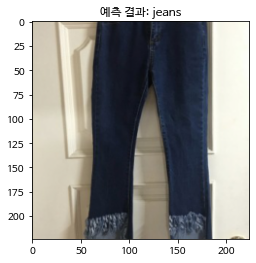

[Test Phase] Loss: 0.5693 Acc: 83.3333% Time: 32.5570s


In [9]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in tqdm_notebook(test_dataloader, desc="training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [ ]:
from PIL import Image


# image = Image.open('/Users/ppangppang/Desktop/ssac/Final_project/2.Processed/image/test/')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])